In [63]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ballmapper.pyBallMapper import BallMapper

import catboost as cb

In [2]:
def generate_tpf(n=100, sigma=0.1):
    unif = ss.uniform()
    norm = ss.norm(loc=0, scale=sigma)
    x = unif.rvs(n)
    def tpf_(t):
        if t<0.3: return 2*t
        if t>0.7: return 1.4-t # perhaps 1.3-t?
        return 0.6
    y = list(map(tpf_, x))
    y += norm.rvs(n)
    return x, y

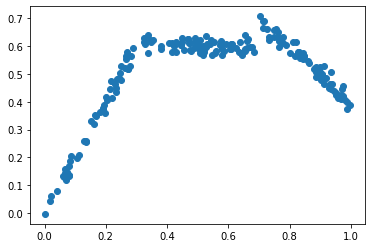

In [3]:
x, y = generate_tpf(n=200, sigma=0.02)
plt.plot(x, y, 'o')

In [ ]:
def rmse_ols(n, sigma, mcloops=1000):
    rmses = []
    for mcloop in range(mcloops):
        x, y = generate_tpf(n=n, sigma=sigma)
        X = x.reshape(-1,1)
        lm = LinearRegression().fit(X,y)
        rmse = mean_squared_error(lm.predict(X), y, squared=False)
        rmses.append(rmse)
    return np.mean(rmses) 

In [ ]:
sigmas = [0.02, 0.2, 0.5]
ns = [200, 500, 1000, 2000]
mcloops = 1000
rmses = []
for sigma in sigmas:
    for n in ns:
        rmses.append([sigma, n, rmse_ols(n=n, sigma=sigma, mcloops=mcloops)])

In [ ]:
pd.DataFrame(rmses, columns=['sigma', 'n', 'OLS'])

,sigma,n,OLS
0,0.02,200,0.135165
1,0.02,500,0.136076
2,0.02,1000,0.136357
3,0.02,2000,0.136267
4,0.20,200,0.239125
5,0.20,500,0.240322
6,0.20,1000,0.240775
7,0.20,2000,0.241077
8,0.50,200,0.516054
9,0.50,500,0.516565


In [54]:
class BMLR:
    def __init__(self, epsilon, cut, M, substitution_policy = 'global'):
        self.epsilon = epsilon
        self.cut = cut
        self.M = M
        self.substitution_policy = substitution_policy
        self.npts = None
        self.dpts = None
        self.lm_global = LinearRegression()
        self.ball_mappers = []
        self.in_sample_remse = None
        self.fitted = False
        
        
    def fit(self, x, y):
        self.npts = x.shape[0]
        self.dpts = x.shape[1]
        self.ball_mappers = []
        self.fitted = True
        # fit global model
        if self.substitution_policy == 'global':
            self.lm_global.fit(x,y)
        
        for r_ in range(self.M):
            bm = BallMapper(points=x, coloring_df=pd.DataFrame(y), epsilon=self.epsilon, shuffle=True)
            self.ball_mappers.append(bm)
            for node_id in bm.Graph.nodes:
                ball_pts_ind = bm.Graph.nodes[node_id]['points covered']
                if len(ball_pts_ind) >= self.cut:
                    x_ball = x[ball_pts_ind, :]
                    y_ball = y[ball_pts_ind]
                    lm = LinearRegression().fit(x_ball, y_ball)
                    bm.Graph.nodes[node_id]['beta'] = lm.coef_
                    bm.Graph.nodes[node_id]['intercept'] = lm.intercept_
                else:
                    if self.substitution_policy == 'global':
                        bm.Graph.nodes[node_id]['beta'] = self.lm_global.coef_
                        bm.Graph.nodes[node_id]['intercept'] = self.lm_global.intercept_
                    else:
                        # find nearest big ball
                        min_dist = np.Inf
                        min_id = None
                        small_ball_mean = np.mean(x[ball_pts_ind, :], axis=0)
                        for big_node_id in bm.Graph.nodes:
                            big_pts_ids = bm.Graph.nodes[big_node_id]['points covered']
                            if len(big_pts_ids) >= self.cut:
                                big_ball_mean = np.mean(x[big_pts_ids, :], axis=0)
                                dist = np.linalg.norm(small_ball_mean - big_ball_mean)
                                if dist < min_dist:
                                    min_dist = dist
                                    min_id = big_node_id
                        # make Linear Model in big ball
                        # TODO: This could be rearrange
                        # 1. first build models only in big-balls
                        # 2. iterate over small balls and copy the model from big balls
                        # thanks to that we don't have to fit linear model inside big-balls multiple times
                        if min_id == None:
                            raise ValueError(f'All ball contain less than cut={self.cut} points. Decrease cut or increase epsilon!')
                        big_pts_ids = bm.Graph.nodes[min_id]['points covered']
                        lm_big = LinearRegression().fit(x[big_pts_ids, :], y[big_pts_ids])
                        bm.Graph.nodes[node_id]['beta'] = lm_big.coef_
                        bm.Graph.nodes[node_id]['intercept'] = lm_big.intercept_    

        # # compute in-sample RMSE, this should be moved to separate function like score?
        # # make insample predictions
        # yhat = [0] * self.npts   # TODO: change list to array
        # counts = [0] * self.npts # TODO: change list to array
        # for bm in self.ball_mappers:
        #     # get a list of nodes to which all test points belongs
        #     # for each point a list of nodes ids is returned
        #     ball_idxs = bm.find_balls(x)
        #     # loop over balls to which all test points belongs, this is in fact loop over test points
        #     for pt_id, ball_idx in enumerate(ball_idxs):
        #         xp = x[pt_id, :]
        #         if ball_idx is not None:
        #             # given test point can belong to many balls, loop over all of those
        #             # each of these balls covers several points from the trainig set
        #             # here we get a list of training points ids
        #             for node_idx in ball_idx:
        #                 yhat[pt_id] += np.matmul(bm.Graph.nodes[node_idx]['beta'], xp) + bm.Graph.nodes[node_idx]['intercept']
        #                 counts[pt_id] += 1
        # yhat = np.array(yhat)
        # counts = np.array(counts)
        # yhat /= counts
        #self.in_sample_remse = mean_squared_error(yhat, y, squared=False)
                
    def predict(self, x_test):
        if not self.fitted:
            raise ValueError('Cannot run predict(). Run fit() first')
        
        npts_test = x_test.shape[0]
        
        yhat = [0] * npts_test   # TODO: change list to array
        counts = [0] * npts_test # TODO: change list to array

        n_Nones = 0
        
        # iterate over all mappers
        for bm in self.ball_mappers:
            # get a list of nodes to which all test points belongs
            # for each point a list of nodes ids is returned
            ball_idxs = bm.find_balls(x_test)
            # loop over balls to which all test points belongs, this is in fact loop over test points
            for pt_id, ball_idx in enumerate(ball_idxs):
                xp = x_test[pt_id, :]
                if ball_idx[0] is not None:
                    #print(ball_idx)
                    # given test point can belong to many balls, loop over all of those
                    # each of these balls covers several points from the trainig set
                    # here we get a list of training points ids
                    for node_idx in ball_idx:
                        yhat[pt_id] += np.matmul(bm.Graph.nodes[node_idx]['beta'], xp) + bm.Graph.nodes[node_idx]['intercept']
                        counts[pt_id] += 1.0
                else:
                    n_Nones += 1
        yhat = np.array(yhat)
        counts = np.array(counts)
        # print(yhat)
        # print(counts)
        # print(n_Nones)
        yhat /= counts
        return yhat
        
    def score(self, x, y):
        yhat = self.predict(x)
        rmse = mean_squared_error(yhat, y, squared=False)
        return rmse

In [15]:
# some test
x, y = generate_tpf(n=200, sigma=0.02)
x_test, y_test = generate_tpf(n=40, sigma=0.02)
x = x.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [31]:
bmlr = BMLR(epsilon=0.1, cut=0, M=5, substitution_policy='global')
bmlr.fit(x,y)
# this should be the same as bmlr.in_sample_remse
print(bmlr.score(x, y))
print(bmlr.score(x_test, y_test))

0.022517611767426185
0.020071113454161783


In [71]:
mcloops = 10
cut = 25
M = 10

rmses = []
epsilon_list = np.linspace(0.075, 0.3, 10)
for epsilon in epsilon_list:
    print(f'epsilon={epsilon}')
    rmses_epsilon = []
    for mcloop in range(mcloops): 
        x_train, y_train = generate_tpf(n=200, sigma=0.02)
        x_test, y_test = generate_tpf(n=40, sigma=0.02)
        x_train = x_train.reshape(-1,1)
        x_test = x_test.reshape(-1,1)

        bmlg = BMLR(epsilon=epsilon, cut=cut, M=M, substitution_policy='global')
        bmln = BMLR(epsilon=epsilon, cut=cut, M=M, substitution_policy='nearest')
        bmlg.fit(x_train, y_train)
        bmln.fit(x_train, y_train)

        rmseg_in  = bmlg.score(x_train, y_train)
        rmseg_out = bmlg.score(x_test, y_test)
        rmsen_in  = bmln.score(x_train, y_train)
        rmsen_out = bmln.score(x_test, y_test)
        
        # train catboost
        train_dataset = cb.Pool(x_train, y_train)
        test_dataset = cb.Pool(x_test, y_test)
        model = cb.CatBoostRegressor(loss_function='RMSE')
        model.fit(train_dataset, eval_set=test_dataset, use_best_model=True, verbose=0)
        cb_score = model.best_score_['validation']['RMSE']
        
        rmses_epsilon.append([rmseg_in, rmsen_in, rmseg_out, rmsen_out, cb_score])
    rmses_epsilon = np.mean(rmses_epsilon, axis=0)
    rmses.append([epsilon, *rmses_epsilon])

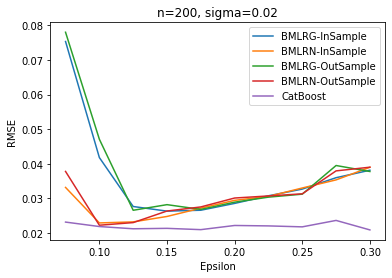

In [72]:
rmses = np.array(rmses)
plt.plot(rmses[:, 0], rmses[:, 1], label='BMLRG-InSample')
plt.plot(rmses[:, 0], rmses[:, 2], label='BMLRN-InSample')
plt.plot(rmses[:, 0], rmses[:, 3], label='BMLRG-OutSample')
plt.plot(rmses[:, 0], rmses[:, 4], label='BMLRN-OutSample')
plt.plot(rmses[:, 0], rmses[:, 5], label='CatBoost')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('n=200, sigma=0.02')
plt.legend()